In [ ]:
# TODO: Make sure portfolio factors are in factor set
# TODO: Try diagonal and uniform correlatoins (totally uncorrelated and correlated) (think about the circle)
# TODO: Make sure we're finding global minimum
# TODO: With and without portfolio
# TODO: Emphasize hyperfactors
# TODO: Paramters - factors, dates, correlation

# TODO: Remove first principal component... make it beta neutral

In [2]:
from typing import Optional, List
from importlib import reload
import pandas as pd

from data import get_yf_data, get_factor_master, get_portfolios, get_factor_data
from stats import get_volatility_set, get_correlation_set
from util import xr_pct_change, safe_reindex

from corr_mds import *

In [3]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

In [4]:
# def get_factor_data_port(halflifes: Optional[List[int]] = None) -> xr.Dataset:
# if halflifes == None:
#     halflifes = [21, 63, 126, 252, 512]

factor_master = get_factor_master(sheet_name='read')
asset_list = factor_master.loc[factor_master['composite'] == 0].index.to_list()
portfolios = get_portfolios().pipe(safe_reindex, factor_master).fillna(0).loc[asset_list]


In [5]:
ds = xr.Dataset()
ds['ohlcv'] = get_yf_data(asset_list) #.to_dataset(name='ohlcv')
ds['cret']  = ds['ohlcv'].sel(ohlcv_type='adj close')
# ds['ret']   = xr_pct_change(ds['cret'], 'date')

asset_ret = xr_pct_change(ds['cret'], 'date').to_pandas()
portfolios_ret = asset_ret @ portfolios


[*********************100%%**********************]  55 of 55 completed


In [6]:
halflifes = [21, 63]

factor_data2 = xr.Dataset()
# factor_data2['ret'] = pd.concat([asset_ret, portfolios_ret], axis=1).rename_axis(columns='asset')
factor_data2['ret'] = (pd.concat([asset_ret['MWTIX'], portfolios_ret, asset_ret.drop(columns=['MWTIX'])], axis=1)
                       .rename_axis(columns='asset'))
factor_data2['vol']   = get_volatility_set(factor_data2['ret'], halflifes)
factor_data2['corr']  = get_correlation_set(factor_data2['ret'], halflifes)
factor_data2['cret']  = factor_data2['ret'].cumsum(dim='date')

factor_data2['asset'].attrs = factor_master.T.to_dict()


In [7]:
   
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *


def run_mds(corr, transformation, start_date, tick_range, **kwargs):
    t0 = '2024-11-18'
    t1 = '2024-10-18'
    # t1 = '2024-11-05'
    t2 = '2024-08-14'

    # (t0, t1, t2) = factor_data2.date.values[[-1, -21-1, -63-1]]

    transformation_type = {None:             'No rotation', 
                           'rotate':         'Rotate SPY to x-axis each day', 
                           'normalize':      'SPY transformed to (1, 0)',
                           'rotate_initial': '' #'Rotate SPY to x-axis today'
                           }

    mds_ts = (mds_ts_df(factor_data2.corr, transformation=transformation, start_date='2024', **kwargs)
                .reset_index()
                .join(factor_master, on='asset')
                .assign(date = lambda df: df['date'].astype(str))
                # .assign(size = lambda df: df['hyper_factor'].mul(1).add(.5).astype('float'))
                .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
                .replace('MWTIX', 'TCW')
                )
    mds_latest = mds_ts[mds_ts['date'] == t0].drop(columns='date')
    fig = draw_mds_ts(mds_latest, tick_range=tick_range)
    fig = add_whiskers(fig, mds_ts, t0, t1)
    fig = add_whiskers(fig, mds_ts, t1, t2)
    fig.update_layout(legend_title_text=None, title=f'{transformation_type[transformation]}')
        
    r = sqrt(2)/2

    fig.add_shape(
        type="circle",
        xref="x", yref="y",
        x0=-r, y0=-r, x1=r, y1=r,
        line_color='lightgray', line_width=.5,
        )
    
    return fig

# mds_previous = mds_ts[mds_ts['date'] == t1].drop(columns='date')
# fig_previous = (draw_mds_ts(mds_previous, tick_range=1.5)
#                 .update_traces(text=None,  opacity=0.3) # marker_size=5,
#                 .update_layout(showlegend=False))
# for trace in fig_previous.data:
#     trace.showlegend = False
#     fig.add_trace(trace)

# for trace in fig.data:
#     if trace.mode == 'lines':
#         for marker_trace in fig.data:
#             if marker_trace.mode == 'markers+text' and marker_trace.name == trace.legendgroup:
#                 trace.update(line=dict(color=marker_trace.marker.color))
#                 break


c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 100
  warnings.warn(
c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 100
  warnings.warn(
c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 100
  warnings.warn(
c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 100
  warnings.warn(
c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 100
  warnings.w

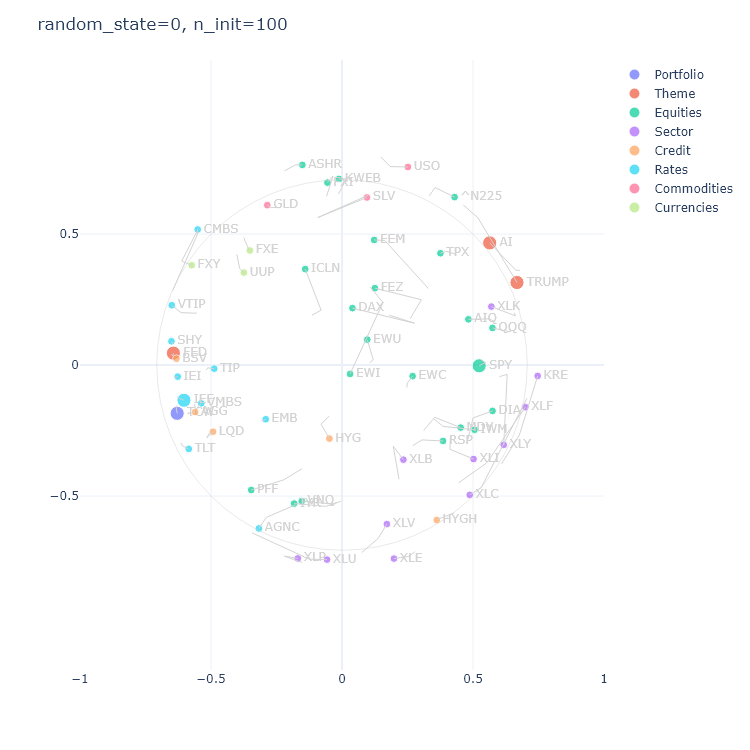

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 100

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 100

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 100

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 100

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifold\_mds.py:342: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 100

c:\Users\bkrai\Source\venv-python312\Lib\site-packages\sklearn\manifol

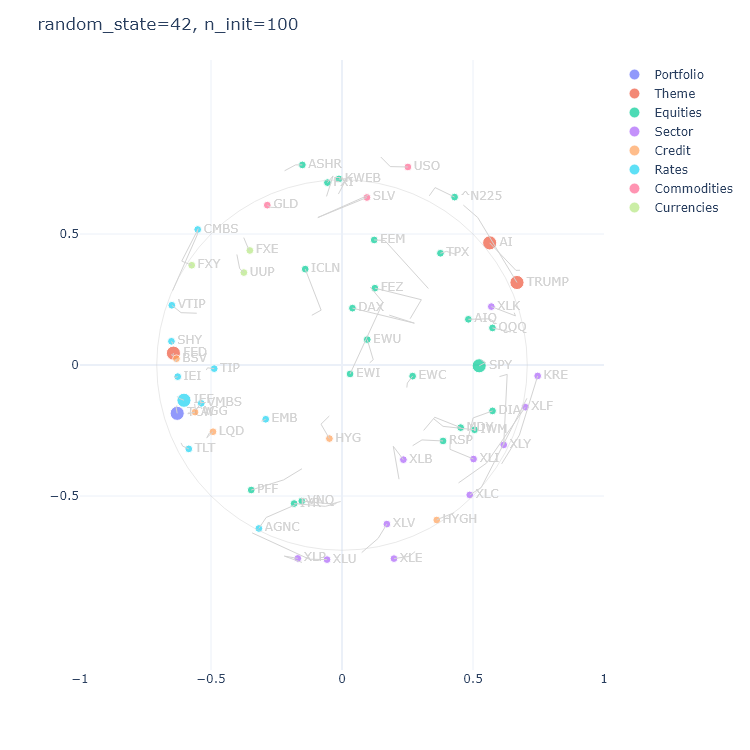

In [8]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

# TODO: Do the args work?!

args = {'random_state': 0, 
        'n_init': 100}
fig = (run_mds(factor_data2.corr, 
              transformation='rotate_initial', 
              start_date='2004', 
              tick_range=1,
              **args)
       .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}"))
fig.show(renderer='png')

args = {'random_state': 42, 
        'n_init': 100}
fig = (run_mds(factor_data2.corr, 
              transformation='rotate_initial', 
              start_date='2004', 
              tick_range=1,
              **args)
       .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}"))
fig.show(renderer='png')



# Try uncorelated matrix (Lambda=I, and Lambda=1)

In [9]:
# factor_data2.corr.sel(date='2024-11-18', corr_type=63).to_pandas().style

In [10]:
# reload(corr_mds)
# run_mds(factor_data2.corr, transformation=None, start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate', start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate_initial', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='rotate_list', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range=1).show(renderer='png')
# # fig.show(renderer='png')


# Market Feedback

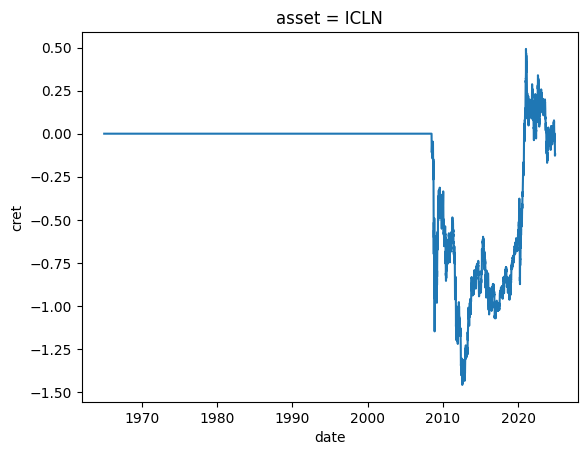

In [11]:
factor_data2.cret.sel(asset='ICLN').plot()

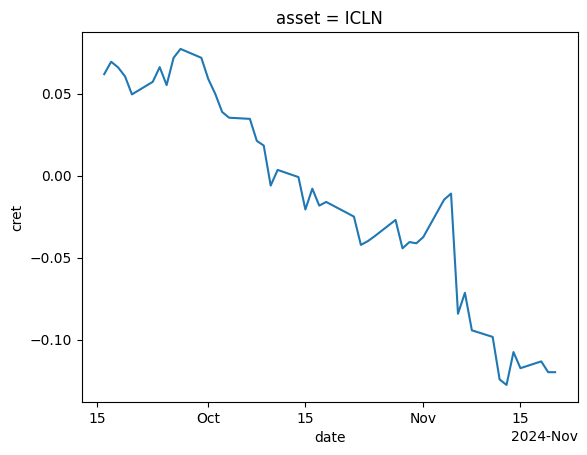

In [12]:
xr_pct_change(factor_data2.cret.sel(asset='ICLN'), dim='date', periods=21)

factor_data2.cret.sel(asset='ICLN', date=slice('2024-9-14', None)).plot()

In [13]:
def accumulate(da_ret, t0, t1, dim='date'):
    # return (da_ret.sel(date=slice(t0, t1))+1).cumprod('date')-1
    return (da_ret.sel({dim: slice(t0, t1)})+1).cumprod(dim) #-1

t0 = '2024-10-14'
t1 = '2024-11-14'

accumulate(factor_data2.ret, t0, t1).to_pandas()


# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()

asset,MWTIX,TRUMP,FED,AI,SPY,IWM,MDY,RSP,QQQ,DIA,...,AGNC,VMBS,CMBS,EMB,GLD,SLV,USO,UUP,FXE,FXY
date,,,,,,,,,,,,,,,,,,,,,
2024-10-14,0.998909,1.000000,1.000000,1.000000,1.008178,1.007367,1.006007,1.007337,1.008391,1.005038,...,1.005820,0.999139,0.995633,1.002064,0.998370,0.990972,0.979868,1.003122,0.997523,0.995801
2024-10-15,1.002181,1.000000,1.000000,1.000000,1.000345,1.008180,1.003368,1.002779,0.994912,0.997224,...,1.013579,1.001506,0.998960,1.004780,1.001833,0.996875,0.938960,1.003815,0.995740,0.999031
2024-10-16,1.003272,1.027564,1.001375,0.986877,1.004693,1.024767,1.012517,1.009561,0.995034,1.004642,...,1.017459,1.002582,1.001871,1.007278,1.006844,1.003819,0.934314,1.006590,0.993362,0.996124
2024-10-17,0.998909,1.038181,0.999372,0.988156,1.004779,1.021965,1.013489,1.007949,0.995723,1.008677,...,1.014549,0.998278,0.996257,1.000869,1.012873,1.003125,0.937153,1.009712,0.990588,0.992571
2024-10-18,0.998909,1.019998,1.000860,1.004864,1.008644,1.019841,1.013819,1.010951,1.002250,1.009468,...,1.028128,0.999139,0.996673,1.003150,1.023628,1.063889,0.921151,1.006937,0.993956,0.998062
2024-10-21,0.991276,1.011581,0.996969,1.019411,1.006988,1.003796,1.002118,1.002335,1.004176,1.001838,...,1.006790,0.991392,0.992098,0.993265,1.023424,1.071181,0.932507,1.011446,0.989597,0.989180
2024-10-22,0.990185,1.010899,0.996848,1.021400,1.006453,1.000000,0.995642,0.997832,1.005270,1.001698,...,0.970902,0.991392,0.991682,0.990984,1.034464,1.102083,0.954704,1.012487,0.987615,0.987565
2024-10-23,0.988004,1.024195,0.995220,1.000652,0.997257,0.990871,0.989566,0.994553,0.989865,0.992015,...,0.964112,0.989025,0.989603,0.987291,1.021999,1.066319,0.949155,1.015956,0.987021,0.977552
2024-10-24,0.989095,1.017295,0.996215,1.014687,0.999413,0.993040,0.991476,0.994775,0.997892,0.988795,...,0.964112,0.990101,0.991058,0.991310,1.029861,1.065625,0.942831,1.012140,0.990786,0.982397


In [14]:
from util import xr_pct_change

date_latest = pd.to_datetime(factor_data2.date.max().item())
date_latest = '2024-11-14'
vol_type = 63

vol = factor_data2.vol.sel(date=date_latest, vol_type=vol_type).to_series()
# ret = factor_data.ret.sel(date=date_latest).to_series()
ret = xr_pct_change(factor_data2.cret, dim='date', periods=21).sel(date=date_latest).to_series().rename('ret').mul(100)


df = pd.concat([ret, vol, factor_master], axis=1).reset_index()

fig_format = {'template': 'plotly_white', 'height': 750, 'width': 750}
fig = (px.scatter(df, x='vol', y='ret', color='asset_class', text='index', **fig_format)
       .update_traces(textposition='middle right', 
                      textfont_color='lightgray')
       .update_layout(# xaxis_title=None,
                      # yaxis_title=None,
                      # xaxis_showticklabels=False,
                      # yaxis_showticklabels=False,
                      # xaxis_showgrid=False,
                      # yaxis_showgrid=False,
                      xaxis_showline=False,
                      yaxis_showline=False,
                      legend_title_text=None,
                      )
       )

# fig.show(renderer='png')
fig.show()

<Axes: xlabel='date'>

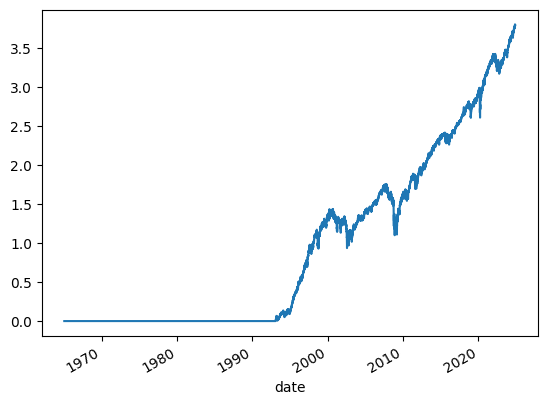

In [15]:
factor_data2['cret'].to_pandas()['SPY'].plot()

In [16]:

# ds1 = factor_data2.sel(asset='SPY')
# ds1.ret.to_pandas().sort_index(ascending=False).to_clipboard()
# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()
# xr_pct_change(((ds1.ret+1).cumprod('date')-1), dim='date', periods=1).to_pandas().sort_index(ascending=False).to_clipboard()

# # xr_pct_change(((factor_data2.ret.sel(asset='SPY')+1).cumprod('date')-1), dim='date', periods=1).to_pandas().to_clipboard()